In [1]:
!pip install transformers
!pip install pandas
!pip install matplotlib
!pip install seaborn


     ---------------------------------------- 0.0/43.8 kB ? eta -:--:--
     ---------------------------------------- 43.8/43.8 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB ? eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
    --------------------------------------- 0.1/9.1 MB 3.6 MB/s eta 0:00:03
    --------------------------------------- 0.2/9.1 MB 2.5 MB/s eta 0:00:04
   - -------------------------------------- 0.3/9.1 MB 2.7 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/9.1 MB 2.9 MB/s eta 0:00:04
   --- ------------------------------------ 0.9/9.1 MB 3.9 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/9.1 MB 4.6 MB/s eta 0:00:02
   ----- ------------------------

In [3]:
!pip install torch

   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/159.8 MB 13.2 MB/s eta 0:00:13
   ---------------------------------------- 0.9/159.8 MB 11.3 MB/s eta 0:00:15
   ---------------------------------------- 1.4/159.8 MB 11.1 MB/s eta 0:00:15
   ---------------------------------------- 1.9/159.8 MB 11.1 MB/s eta 0:00:15
    --------------------------------------- 2.5/159.8 MB 11.2 MB/s eta 0:00:15
    --------------------------------------- 3.0/159.8 MB 11.2 MB/s eta 0:00:14
    --------------------------------------- 3.5/159.8 MB 11.3 MB/s eta 0:00:14
   - -------------------------------------- 4.0/159.8 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 4.6/159.8 MB 11.3 MB/s eta 0:00:14
   - -------------------------------------- 5.1/159.8 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 5.6/159.8 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 6.1/159.8 MB 11.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn.functional as F

## 전처리

In [111]:
# 데이터 불러오기
df = pd.read_csv('./알리_베스트셀러_리뷰.csv',encoding='utf-8', sep=',')

# 데이터 샘플 확인
df.head(3)

상품명     가격   평점  \
0  SCVCN 사이클링 안경 자전거 선글라스, 남성 UV400 안경, 스포츠 MTB 야...  1,391  4.7   
1  역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...  1,391  4.8   
2  야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...  1,125  4.7   

                                                  댓글  \
0                                                NaN   
1  배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...   
2  감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...   

                                                  별점  \
0                                                NaN   
1  5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...   
2  5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...   

                                                  링크  
0  https://ko.aliexpress.com/item/100500592463696...  
1  https://ko.aliexpress.com/item/100500592457862...  
2  https://ko.aliexpress.com/item/100500522141320...

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   상품명     291 non-null    object 
 1   가격      291 non-null    object 
 2   평점      291 non-null    float64
 3   댓글      270 non-null    object 
 4   별점      286 non-null    object 
 5   링크      291 non-null    object 
dtypes: float64(1), object(5)
memory usage: 13.8+ KB


In [113]:
rawdf = df.copy()

rawdf = rawdf.dropna(subset=['댓글'])

In [114]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 1 to 290
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   상품명     270 non-null    object 
 1   가격      270 non-null    object 
 2   평점      270 non-null    float64
 3   댓글      270 non-null    object 
 4   별점      270 non-null    object 
 5   링크      270 non-null    object 
dtypes: float64(1), object(5)
memory usage: 14.8+ KB


In [115]:
import re
# 텍스트 정제 함수
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 'cleaned_text' 컬럼 추가
rawdf['정제댓글'] = rawdf['댓글'].apply(clean_text)

In [116]:
rawdf.head()

상품명      가격   평점  \
1  역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...   1,391  4.8   
2  야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...   1,125  4.7   
3  접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...  25,785  4.7   
4  BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, ...  16,411  4.8   
5  튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 필라테스 체육관 피트니...   1,391  4.7   

                                                  댓글  \
1  배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...   
2  감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...   
3  뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...   
4  생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...   
5  잘받았습니다\n좋아요 가격대비 만족합니다\n진짜 빨리받앗어요. 일주일?? 턱걸이하는...   

                                                  별점  \
1  5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...   
2  5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...   
3  5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...   
4  5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n5\n5\n5\n5\n5...   
5  5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n4\n4\n4\n4\n5...   

                                                  링크  \
1  https://ko.aliexpress.com/item/100500592457862...   
2  https://ko.aliexpress.com/item/100500522141320...   
3  https://ko.aliexpress.com/item/100500593200533...   
4  https://ko.aliexpress.com/item/100500626084886...   
5  https://ko.aliexpress.com/item/100500545860164...   

                                                정제댓글  
1  배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍레드 디자인 이쁘고 마감처리 깔끔하고...  
2  감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...  
3  뭔 배송하면서 바닷물에 담궈서 가져오냐 쓰기도 전에 녹슬어서 오는 메이드인 차이나 ...  
4  생각보다 너무괜찮은데요 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사고...  
5  잘받았습니다\n좋아요 가격대비 만족합니다\n진짜 빨리받앗어요 일주일 턱걸이하는데 아...

In [117]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 1 to 290
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   상품명     270 non-null    object 
 1   가격      270 non-null    object 
 2   평점      270 non-null    float64
 3   댓글      270 non-null    object 
 4   별점      270 non-null    object 
 5   링크      270 non-null    object 
 6   정제댓글    270 non-null    object 
dtypes: float64(1), object(6)
memory usage: 16.9+ KB


In [118]:
rawdf.shape

(270, 7)

In [119]:
rawdf['댓글'][1]

'배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하고 스트랩 로고처리로 고급져보이네요 스트랩에 미끄럽지 않게 미끄렁방지 처리까지 되어있네요 저렴하게 구매할수 있어 정말 만족합니다 강력 추천하고 싶네요 ㅋ\n배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ\n정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩에 비교해도 기능성으로는 전혀 문제가 없을듯합니다. 착용감은 좋은데 사용전이라 장시간 사용했을때 실리콘이 안떨어지길 바래봅니다. 아 바느질은 좀 거친감이 있습니다.\n3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼방지 처리도 깔끔하게 잘 되어있어서 가성비 너무 좋게 잘 샀습니다~\n아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.\n아주 고퀄은 아니지만 스트랩이란건 튼튼하면 그만이니 이 가격은 아주아주 혜자. 깔별로 사모으는것도 재밋을듯요\n한번에 다왔습니다. 배송이 조금 늦어져서 쿠폰도 받고 했지만.. 그래도 안전하게 배송 잘왔습니다. 주문하실때 여러번 나눠서 주문하면 통관하는데 오래 걸리는듯 합니다. 잘왔습니다~ 잘쓰겠습니다.\n저렴해서 기대 안했는데 미끄럼 방지도 돼있네요. 좋아요\n배송은 조금 느리지만 상품은 좋습니다.\n좋습니다 좋겠습니다 좋으네 좋아요\n좋아용\n매우 만족합니다. 좋아요~~^^\n배송도빠르고 저렴하고좋습니다 ㅎㅎ\n좋습니다\n가격 저렴하고 쓸만합니다\n가격대비 품질 좋은 편. 내구성은 오래 안 써봐서 아직 모름. 마프 스트랩 썼었는데 마프꺼보다 쿠션은 훨씬 말랑하고 스트랩은 얇은 편. 완전 면 재질은 아님. 그래도 가격대비 이 정도면 만족. 사용성만 좋으면 여기로 정착할 듯. 개인적으로 미끄럼방지 고무가 바벨 쪽이 아니라 손에 있었으면 좋았을 듯. 원래 손 쪽에 있는 거라던데..\n대만족입니다\n싸고 좋다 그냥 사라\n품질이 좋아. 바벨과 닿는면에 실리콘 처리까지 되어있고, 손목에는 쿠션도

In [120]:
# 댓글들 각각에 인덱스를 부여하는 작업
# 이 작업을 통해서 각 댓글의 긍정, 부정을 라벨링 할 것임
def split_review(review):
    return list(map(str, review.split('\n')))

# review_list 컬럼을 만들어 댓글들을 인덱스 번호 하나하나에 배치
rawdf['review_list'] = rawdf['댓글'].apply(split_review)

# 별점을 정수형 리스트로 변환
def split_stars(stars):
    return list(map(int, stars.split('\n')))


# 각 행에 대해 별점 리스트로 변환
rawdf['star_list'] = rawdf['별점'].apply(split_stars)

# 별점 리스트를 긍정/부정 리스트로 변환
def classify_star_list(star_list):
    return [ 1 if star in [4, 5] else 0 for star in star_list]

# label이라는 새로운 컬럼을 만들어 별점 리스트에 대한 긍정/부정 리스트 추가
rawdf['label'] = rawdf['star_list'].apply(classify_star_list)

In [121]:
# 리뷰리스트에 인덱스가 290까지 되어 있지만 265개가 실 데이터이기 때문에 reset_indet를 통해 다시 인덱싱함
rawdf['review_list'].reset_index(drop=True, inplace=False)

0      [배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔...
1      [감사합니다, 지퍼 손잡이 매듭용으로 좋습니다, 잘받았습니다 잘받았습니다, 이색인줄...
2      [뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이...
3      [생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저...
4      [잘받았습니다, 좋아요 가격대비 만족합니다, 진짜 빨리받앗어요. 일주일?? 턱걸이하...
                             ...                        
265    [접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고 좋...
266    [케이블이 두껍네요. 고속충전 잘 됩니다., 괜찮네요 120w까지 되는지 확인은 못...
267    [택배 수령 이후 매일 사용해 보았습니다. 성능도 충분하고 발열문제도 없이 안정적으...
268    [검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습니다...
269    [상품이 좋습니다, 만족합니다. 추천합니다, 감사합니다 잘 쓰겠습니다, 필요한제품인...
Name: review_list, Length: 270, dtype: object

In [122]:
len(rawdf['review_list'])

270

In [123]:
# 필요없는 컬럼 정리
train_df_clean = rawdf.drop(columns=['평점','댓글','별점','링크','star_list'])

In [124]:
# 인덱스 정리  (290개로 인덱싱이 되어 있는데 실 데이터는 270개 임으로 인덱스 정리 필요)
train_df_clean.reset_index(drop= True, inplace= True)

In [125]:
train_df_clean.tail()

상품명      가격  \
265  아이폰용 마그네틱 오리지널 맥세이프 케이스, 실리콘 아크릴, 맥세이프 커버, 13,...   1,402   
266  아이폰 15 샤오미 원플러스 휴대폰용 C타입 케이블, 고속 충전 USB C타입 케이...   1,402   
267  Toocki 데스크탑 고속 충전 USB C 타입 충전기, 아이폰 샤오미 스마트폰 노...  36,215   
268  아이폰 X XR XS 맥스 11 12 프로 맥스용 OLED 스크린 LCD 디스플레이...  11,496   
269  OTG USB 3.0 to C타입 어댑터, USB 암 to C타입 수 고속 충전 어...   1,455   

                                                  정제댓글  \
265  접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고 좋아...   
266  케이블이 두껍네요 고속충전 잘 됩니다\n괜찮네요 120w까지 되는지 확인은 못 하지...   
267  택배 수령 이후 매일 사용해 보았습니다 성능도 충분하고 발열문제도 없이 안정적으로 ...   
268  검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습니다 ...   
269  상품이 좋습니다\n만족합니다 추천합니다\n감사합니다 잘 쓰겠습니다\n필요한제품인데 ...   

                                           review_list  \
265  [접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고 좋...   
266  [케이블이 두껍네요. 고속충전 잘 됩니다., 괜찮네요 120w까지 되는지 확인은 못...   
267  [택배 수령 이후 매일 사용해 보았습니다. 성능도 충분하고 발열문제도 없이 안정적으...   
268  [검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습니다...   
269  [상품이 좋습니다, 만족합니다. 추천합니다, 감사합니다 잘 쓰겠습니다, 필요한제품인...   

                                                 label  
265  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
266  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
267  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
268  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...  
269  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...

In [126]:
train_df_clean['review_list']

0      [배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔...
1      [감사합니다, 지퍼 손잡이 매듭용으로 좋습니다, 잘받았습니다 잘받았습니다, 이색인줄...
2      [뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이...
3      [생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저...
4      [잘받았습니다, 좋아요 가격대비 만족합니다, 진짜 빨리받앗어요. 일주일?? 턱걸이하...
                             ...                        
265    [접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고 좋...
266    [케이블이 두껍네요. 고속충전 잘 됩니다., 괜찮네요 120w까지 되는지 확인은 못...
267    [택배 수령 이후 매일 사용해 보았습니다. 성능도 충분하고 발열문제도 없이 안정적으...
268    [검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습니다...
269    [상품이 좋습니다, 만족합니다. 추천합니다, 감사합니다 잘 쓰겠습니다, 필요한제품인...
Name: review_list, Length: 270, dtype: object

In [127]:
train_df_clean = train_df_clean[['review_list','label']]

In [128]:
train_df_clean.to_csv('./review_list_label.csv', encoding='utf-8', index= False)

In [129]:
raw = pd.read_csv('./review_list_label.csv')
raw

review_list  \
0    ['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...   
1    ['감사합니다', '지퍼 손잡이 매듭용으로 좋습니다', '잘받았습니다 잘받았습니다'...   
2    ['뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차...   
3    ['생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ ...   
4    ['잘받았습니다', '좋아요 가격대비 만족합니다', '진짜 빨리받앗어요. 일주일??...   
..                                                 ...   
265  ['접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고 ...   
266  ['케이블이 두껍네요. 고속충전 잘 됩니다.', '괜찮네요 120w까지 되는지 확인...   
267  ['택배 수령 이후 매일 사용해 보았습니다. 성능도 충분하고 발열문제도 없이 안정적...   
268  ['검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습니...   
269  ['상품이 좋습니다', '만족합니다. 추천합니다', '감사합니다 잘 쓰겠습니다', ...   

                                                 label  
0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  
2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
..                                                 ...  
265  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
266  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
267  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
268  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...  
269  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...  

[270 rows x 2 columns]

In [130]:
df = raw.copy()

In [131]:
df.head()

review_list  \
0  ['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...   
1  ['감사합니다', '지퍼 손잡이 매듭용으로 좋습니다', '잘받았습니다 잘받았습니다'...   
2  ['뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차...   
3  ['생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ ...   
4  ['잘받았습니다', '좋아요 가격대비 만족합니다', '진짜 빨리받앗어요. 일주일??...   

                                               label  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

In [132]:
# 댓글들 각각에 인덱스를 부여하는 작업
# 이 작업을 통해서 각 댓글의 긍정, 부정을 라벨링 할 것임

def split_review(review):
    return list(map(str, review.split(',')))

# review_list 컬럼을 만들어 댓글들을 인덱스 번호 하나하나에 배치
df['review_list'] = df['review_list'].apply(split_review)

In [133]:
import re
import pandas as pd

def split_score(score):
    numbers = re.findall(r'\d+', score)
    return list(map(int, numbers))

# 예제 데이터프레임 생성
#data = {'label': ["[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]"]}
#df = pd.DataFrame(data)

# 'label' 컬럼에 대해 split_score 함수 적용
df['label'] = df['label'].apply(split_score)

In [134]:
df.head()

review_list  \
0  [['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 ...   
1  [['감사합니다',  '지퍼 손잡이 매듭용으로 좋습니다',  '잘받았습니다 잘받았습...   
2  [['뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 ...   
3  [['생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ...   
4  [['잘받았습니다',  '좋아요 가격대비 만족합니다',  '진짜 빨리받앗어요. 일주...   

                                               label  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

In [135]:
df['review_list']

0      [['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 ...
1      [['감사합니다',  '지퍼 손잡이 매듭용으로 좋습니다',  '잘받았습니다 잘받았습...
2      [['뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 ...
3      [['생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ...
4      [['잘받았습니다',  '좋아요 가격대비 만족합니다',  '진짜 빨리받앗어요. 일주...
                             ...                        
265    [['접착력이 약하다는말이 있어서 고민되었는데 싸서 한번사봤는데 너무 너무 짱짱하고...
266    [['케이블이 두껍네요. 고속충전 잘 됩니다.',  '괜찮네요 120w까지 되는지 ...
267    [['택배 수령 이후 매일 사용해 보았습니다. 성능도 충분하고 발열문제도 없이 안정...
268    [['검은화면 뛰어보니 올레드 패널은 아닌거같은데 그거말곤 정품이랑 다 같네요 좋습...
269    [['상품이 좋습니다',  '만족합니다. 추천합니다',  '감사합니다 잘 쓰겠습니다...
Name: review_list, Length: 270, dtype: object

In [136]:
type(expanded_reviews)

list

In [137]:
df_reviews = pd.DataFrame({'reviews' : expanded_reviews})

In [138]:
df_reviews['reviews'][0]

"['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하고 스트랩 로고처리로 고급져보이네요 스트랩에 미끄럽지 않게 미끄렁방지 처리까지 되어있네요 저렴하게 구매할수 있어 정말 만족합니다 강력 추천하고 싶네요 ㅋ'"

In [139]:
df_reviews['reviews'] = df_reviews['reviews'].apply(lambda x : re.sub(r'[^ㄱ-ㅣ가-힣]+', ' ', x ))
df_reviews.head(3)

reviews
0   배송은 생각보다 빨리도착했네요 손목 스트랩 쌍 레드 디자인 이쁘고 마감처리 깔끔하...
1     배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천 ㅋ 
2   정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전...

In [140]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15399 entries, 0 to 15398
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  15399 non-null  object
dtypes: object(1)
memory usage: 120.4+ KB


In [141]:
# 새로운 데이터프레임에 저장할 리스트 초기화
expanded_reviews = []

for i in range(len(df['review_list'])):  # 기존 데이터프레임의 각 행에 대해
    for review in df['review_list'][i]: # 각 리뷰 리스트의 리뷰에 대해all
        expanded_reviews.append(review)

## bert 모델을 이용한 감정 분석

In [142]:
!pip install torch torchvision

In [143]:
model_name = "kykim/bert-kor-base"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

# 입력 문장을 토큰화하고 BERT 입력 형식으로 변환합니다.
text = "This is a sample sentence."
inputs = tokenizer(text, return_tensors="pt")

# 모델을 통해 예측을 수행합니다.
outputs = model(**inputs)

# 출력에서 로짓 값을 얻어 예측 결과를 얻습니다.
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

print("Predicted class:", predicted_class)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 0


In [144]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch

# # 한국어 BERT 모델과 토크나이저를 불러옵니다.
# tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
# model = BertForSequenceClassification.from_pretrained('klue/bert-base')

# # 입력 문장을 토큰화하고 BERT 입력 형식으로 변환합니다.
# text = "한국어 문장을 처리하는 예시입니다."
# inputs = tokenizer(text, return_tensors="pt")

# # 모델을 통해 예측을 수행합니다.
# outputs = model(**inputs)

# # 출력에서 로짓 값을 얻어 예측 결과를 얻습니다.
# logits = outputs.logits
# predicted_class = torch.argmax(logits, dim=1).item()

# print("Predicted class:", predicted_class)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 1


In [148]:
# 한국어 BERT 모델과 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')
model = BertForSequenceClassification.from_pretrained('kykim/bert-kor-base')

# 감정 분석 함수 정의
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

# 댓글 데이터에 감정 분석 적용
df_reviews['감정분석결과'] = df_reviews['reviews'].apply(analyze_sentiment)

# 긍정인지 부정인지 구별하여 새로운 컬럼에 추가
df_reviews['감정'] = df_reviews['감정분석결과'].apply(lambda x: '긍정' if x == 1 else '부정')

# 감정 분류별 댓글 수 계산
sentiment_counts = df_reviews['감정'].value_counts()

print(sentiment_counts)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


감정
긍정    13960
부정     1439
Name: count, dtype: int64


In [ ]:
# # 한국어 BERT 모델과 토크나이저 불러오기
# tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
# model = BertForSequenceClassification.from_pretrained('klue/bert-base')

# # 감정 분석 함수 정의
# def analyze_sentiment(text):
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
#     outputs = model(**inputs)
#     logits = outputs.logits
#     predicted_class = torch.argmax(logits, dim=1).item()
#     return predicted_class

# # 댓글 데이터에 감정 분석 적용
# rawdf['감정분석결과'] = rawdf['댓글'].apply(analyze_sentiment)

# # 감정 분류별 댓글 수 계산
# sentiment_counts = rawdf['감정분석결과'].value_counts()

# print(sentiment_counts)

In [149]:
df_reviews.head()

reviews  감정분석결과  감정
0   배송은 생각보다 빨리도착했네요 손목 스트랩 쌍 레드 디자인 이쁘고 마감처리 깔끔하...       1  긍정
1     배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천 ㅋ        1  긍정
2   정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전...       1  긍정
3   개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼...       1  긍정
4                  아 배송은 일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다        1  긍정

In [ ]:
rawdf.head(3)

상품명      가격   평점  \
1  역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...   1,391  4.8   
2  야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...   1,125  4.7   
3  접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...  25,785  4.7   

                                                  댓글  \
1  배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...   
2  감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...   
3  뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...   

                                                  별점  \
1  5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...   
2  5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...   
3  5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...   

                                                  링크  \
1  https://ko.aliexpress.com/item/100500592457862...   
2  https://ko.aliexpress.com/item/100500522141320...   
3  https://ko.aliexpress.com/item/100500593200533...   

                                                정제댓글  감정분석결과  \
1  배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍레드 디자인 이쁘고 마감처리 깔끔하고...       1   
2  감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...       1   
3  뭔 배송하면서 바닷물에 담궈서 가져오냐 쓰기도 전에 녹슬어서 오는 메이드인 차이나 ...       1   

                                         review_list  \
1  [배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔...   
2  [감사합니다, 지퍼 손잡이 매듭용으로 좋습니다, 잘받았습니다 잘받았습니다, 이색인줄...   
3  [뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이...   

                                           star_list  \
1  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
2  [5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...   
3  [5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...   

                                               label  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

In [ ]:
# rawdf.to_csv('./bert모델.csv',encoding='utf-8-sig')

In [ ]:
# df_reviews.to_csv('bert모델02.csv',encoding='utf-8-sig')

In [150]:
df_reviews.to_csv('bert모델03.csv',encoding='utf-8-sig')

In [2]:
df_reviews = pd.read_csv('bert모델03.csv',encoding='utf-8')

In [151]:
# df_won = pd.read_csv('./review+_labeling_data.csv',encoding='utf-8')

# df_won.head()

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 데이터를 학습용과 테스트용으로 나눔
X_train, X_test, y_train, y_test = train_test_split(df_reviews['reviews'], df_reviews['감정분석결과'], test_size=0.2, random_state=42)

# TF-IDF 피처 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 로지스틱 회귀 모델 학습
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# 테스트 데이터에 대한 예측
y_pred = lr_model.predict(X_test_tfidf)

# 정확도 및 분류 보고서 출력
print("정확도:", accuracy_score(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))


정확도: 0.9074675324675324
분류 보고서:
               precision    recall  f1-score   support

           0       0.40      0.01      0.01       284
           1       0.91      1.00      0.95      2796

    accuracy                           0.91      3080
   macro avg       0.65      0.50      0.48      3080
weighted avg       0.86      0.91      0.87      3080



In [153]:
!pip install wordcloud matplotlib

   ---------------------------------------- 0.0/300.0 kB ? eta -:--:--
   -------- ------------------------------- 61.4/300.0 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 300.0/300.0 kB 6.2 MB/s eta 0:00:00


In [3]:
# 라이브러리 임포트
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# 데이터 준비
# 긍정적인 감정(1)의 리뷰만 추출
positive_reviews = df_reviews[df_reviews['감정분석결과'] == 1]['reviews'].dropna()

In [9]:
# 불용어 리스트 txt 파일 읽기
with open('combined_word_list.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords)
X_tfidf = vectorizer.fit_transform(positive_reviews)

In [10]:
# 단어와 그 중요도를 추출
terms = vectorizer.get_feature_names_out()
sums = X_tfidf.sum(axis=0)
data = [(terms[i], sums[0, i]) for i in range(sums.shape[1])]
ranking = pd.DataFrame(data, columns=['단어', '중요도'])

In [11]:
# 상위 20개 단어 추출
top_20_words = ranking.sort_values('중요도', ascending=False).head(20)

In [12]:
top_20_words.head()

단어         중요도
817    좋아요  886.549601
27     가성비  374.266086
812   좋습니다  341.935932
809    좋네요  276.695749
255  만족합니다  259.339559

In [14]:
# 워드 클라우드 생성
wordcloud = WordCloud(font_path='C:/Windows/Fonts/NanumGothic.ttf', width=800, height=400, background_color='white')
wordcloud = wordcloud.generate_from_frequencies(dict(zip(top_20_words['단어'], top_20_words['중요도'])))

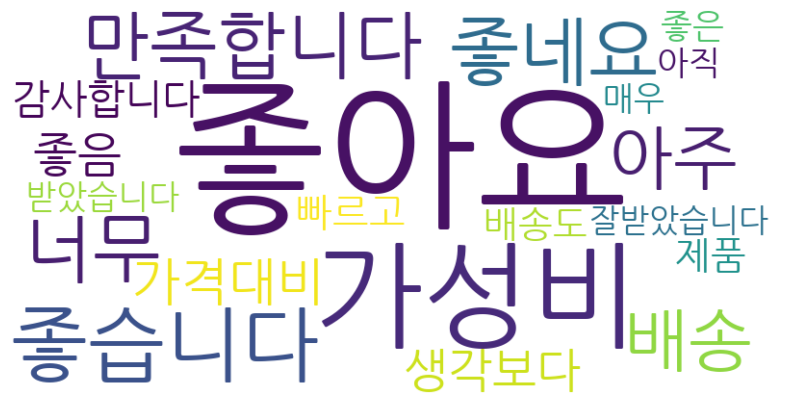

In [15]:
# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
# 부정적인 감정(0)의 리뷰만 추출
negative_reviews = df_reviews[df_reviews['감정분석결과'] == 0]['reviews'].dropna()

In [30]:
# 불용어 리스트 txt 파일 읽기
with open('combined_word_list.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords)
X_tfidf = vectorizer.fit_transform(negative_reviews)

In [31]:
# 단어와 그 중요도를 추출
terms = vectorizer.get_feature_names_out()
sums = X_tfidf.sum(axis=0)
data = [(terms[i], sums[0, i]) for i in range(sums.shape[1])]
ranking = pd.DataFrame(data, columns=['단어', '중요도'])

In [32]:
# 상위 20개 단어 추출
top_20_words = ranking.sort_values('중요도', ascending=False).head(20)

In [36]:
top_20_words.head()

단어        중요도
802   좋아요  46.219215
25    가성비  26.065191
447  생각보다  26.008550
159    너무  23.581762
798  좋습니다  21.843320

In [34]:
# 워드 클라우드 생성
wordcloud = WordCloud(font_path='C:/Windows/Fonts/NanumGothic.ttf', width=800, height=400, background_color='white')
wordcloud = wordcloud.generate_from_frequencies(dict(zip(top_20_words['단어'], top_20_words['중요도'])))

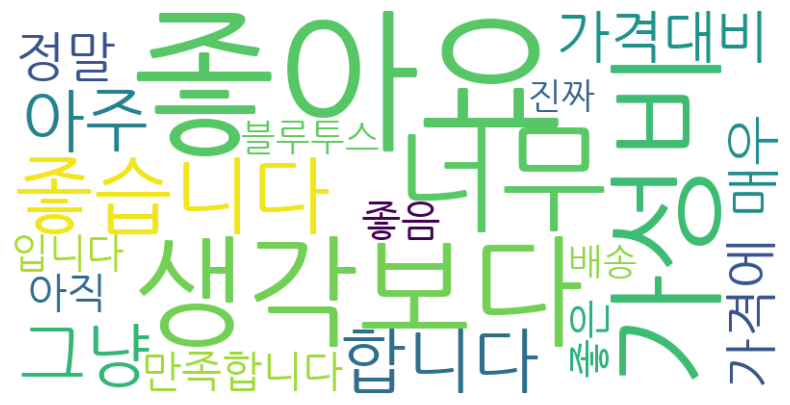

In [35]:
# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## TF-IDF

In [2]:
!pip install networkx scipy matplotlib

INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other requirements. This could take a while.
  Using cached matplotlib-3.8.4-cp310-cp310-win_amd64.whl.metadata (5.9 kB)
Using cached matplotlib-3.8.4-cp310-cp310-win_amd64.whl (7.7 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.0
    Uninstalling matplotlib-3.9.0:
      Successfully uninstalled matplotlib-3.9.0


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer


# 불용어 사전들을 합친 파일을 통해 1차 정제
with open("./combined_word_list.txt", 'r', encoding='utf-8') as file:
    stopwords =[line.strip() for line in file.readlines()]


# 불용어 사전 추가
vehicles_stopwords = ['매우','완전','약간','바로','일만','때문','사서','작고','이건','이번','기존','보임','모조건','전혀','이정', '듭니', '그냥', '다만', '부분', '약간', '다시', '일단', '다른']
for word in vehicles_stopwords:
    stopwords.append(word)
    

ImportError: Matplotlib requires numpy>=1.23; you have 1.22.4

In [64]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

In [68]:
df_reviews.head(3)

Unnamed: 0                                            reviews  감정분석결과  감정
0           0   배송은 생각보다 빨리도착했네요 손목 스트랩 쌍 레드 디자인 이쁘고 마감처리 깔끔하...       1  긍정
1           1     배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천 ㅋ        1  긍정
2           2   정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전...       1  긍정

In [73]:
!pip install konlpy

  Using cached konlpy-0.6.0-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
   ---------------------------------------- 0.0/351.5 kB ? eta -:--:--
   ---------------------- ----------------- 194.6/351.5 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 351.5/351.5 kB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ------ --------------------------------- 0.6/3.8 MB 12.0 MB/s eta 0:00:01
   ----------- ---------------------------- 1.1/3.8 MB 14.0 MB/s eta 0:00:01
   ----------------- ---------------------- 1.7/3.8 MB 13.2 MB/s eta 0:00:01
   ----------------------- ---------------- 2.2/3.8 MB 12.7 MB/s eta 0:00:01
   ---------------------------- ----------- 2.7/3.8 MB 12.5 MB/s eta 0:00:01
   ---------------------------------- ----- 3.3/3.8 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------  3.8/3.8 MB 12.1 MB/s eta 0:00:01
   ----------------------------------

In [78]:
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

# NaN 값 제거
df_reviews.dropna(subset=['reviews'], inplace=True)

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df_reviews['reviews'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [79]:
# 단어 리스트
word_list

array(['가가', '가갹', '가게', ..., '힘껏', '힙니', '힙해'], dtype=object)

In [80]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
count_list

array([1, 1, 5, ..., 1, 2, 1], dtype=int64)

In [81]:
bow_vect.shape

(15352, 6265)

In [82]:
word_count_dict = dict(zip(word_list, count_list))

In [83]:
df_clean_comp = pd.DataFrame(word_count_dict.items(), columns=['명사','빈도'])

In [84]:
df_clean_comp.sort_values('빈도', ascending=False, inplace = True)

In [86]:
df_clean_comp.reset_index(drop=True, inplace=True)

In [87]:
df_review_count = df_clean_comp[0:201]
df_review_count

명사    빈도
0      배송  2451
1      가격  2176
2      사용  1813
3      제품  1724
4      가성  1376
..    ...   ...
196  아이패드    44
197    접착    44
198    자주    43
199    필요    43
200    적극    43

[201 rows x 2 columns]

In [93]:
# '긍정'과 '부정'의 카운트를 저장할 변수 초기화
positive_count = 0
negative_count = 0

# '긍정'과 '부정'을 카운트하는 반복문
for sentiment in df_reviews['감정']:
    if sentiment == '긍정':
        positive_count += 1
    elif sentiment == '부정':
        negative_count += 1

# 결과 출력
print("긍정 리뷰 개수:", positive_count)
print("부정 리뷰 개수:", negative_count)

# DataFrame을 재구성하여 '긍정'과 '부정' 리뷰의 단어 빈도를 함께 확인
df_review_count = pd.DataFrame({'Word': word_list, 'Total_Count': count_list})
df_review_count['Positive_Count'] = 0
df_review_count['Negative_Count'] = 0

# '긍정'과 '부정' 리뷰에서의 단어 빈도를 계산하여 DataFrame에 반영
for index, row in df_reviews.iterrows():
    sentiment = row['감정']
    comment = row['reviews']
    cleaned_comment = text_cleaning(comment)
    for word in cleaned_comment:
        if sentiment == '긍정':
            df_review_count.loc[df_review_count['Word'] == word, 'Positive_Count'] += 1
        elif sentiment == '부정':
            df_review_count.loc[df_review_count['Word'] == word, 'Negative_Count'] += 1

# 결과 확인
print(df_review_count.head())


긍정 리뷰 개수: 13913
부정 리뷰 개수: 1439
  Word  Total_Count  Positive_Count  Negative_Count
0   가가            1               0               1
1   가갹            1               1               0
2   가게            5               3               2
3   가겍            1               1               0
4   가격         2176            1825             351


In [94]:
# 단어 빈도 사전 생성
word_count_dict = dict(zip(word_list, count_list))
df_clean_comp = pd.DataFrame(word_count_dict.items(), columns=['명사', '빈도'])
df_clean_comp.sort_values('빈도', ascending=False, inplace=True)
df_clean_comp.reset_index(drop=True, inplace=True)
df_clean_comp

명사    빈도
0       배송  2451
1       가격  2176
2       사용  1813
3       제품  1724
4       가성  1376
...    ...   ...
6260  서라운드     1
6261    서면     1
6262   서벨로     1
6263    서식     1
6264    힙해     1

[6265 rows x 2 columns]

In [95]:
# 긍정/부정 댓글을 추출합니다
positive_comments = df_reviews[df_reviews['감정'] == '긍정']['reviews'].tolist()
negative_comments = df_reviews[df_reviews['감정'] == '부정']['reviews'].tolist()

# 긍정/부정 댓글에 대한 CountVectorizer 인스턴스를 생성합니다
vect_positive = CountVectorizer(tokenizer=lambda x: text_cleaning(x))
vect_negative = CountVectorizer(tokenizer=lambda x: text_cleaning(x))

# 긍정/부정 댓글을 피팅하고 변환합니다
bow_vect_positive = vect_positive.fit_transform(positive_comments)
bow_vect_negative = vect_negative.fit_transform(negative_comments)

# 긍정/부정 댓글에 대한 피처 이름(단어)를 가져옵니다
word_list_positive = vect_positive.get_feature_names_out()
word_list_negative = vect_negative.get_feature_names_out()

# 긍정/부정 댓글에 대한 단어 카운트를 합산합니다
count_list_positive = bow_vect_positive.toarray().sum(axis=0)
count_list_negative = bow_vect_negative.toarray().sum(axis=0)

# 긍정/부정 댓글에 대한 단어 카운트 딕셔너리를 생성합니다
word_count_dict_positive = dict(zip(word_list_positive, count_list_positive))
word_count_dict_negative = dict(zip(word_list_negative, count_list_negative))

# 긍정/부정 댓글에 대한 데이터프레임을 생성합니다
df_positive = pd.DataFrame(word_count_dict_positive.items(), columns=['단어', '긍정_빈도'])
df_negative = pd.DataFrame(word_count_dict_negative.items(), columns=['단어', '부정_빈도'])

# 긍정/부정 댓글에 대한 단어 카운트를 병합합니다
df_review_count = pd.merge(df_positive, df_negative, on='단어', how='outer').fillna(0)

# 총 빈도수(긍정 + 부정)를 기준으로 정렬합니다
df_review_count['빈도'] = df_review_count['긍정_빈도'] + df_review_count['부정_빈도']
df_review_count.sort_values('빈도', ascending=False, inplace=True)

# 인덱스를 재설정합니다
df_review_count.reset_index(drop=True, inplace=True)

# 데이터프레임을 출력합니다
df_review_count

단어   긍정_빈도  부정_빈도      빈도
0       배송  2197.0  254.0  2451.0
1       가격  1825.0  351.0  2176.0
2       사용  1486.0  327.0  1813.0
3       제품  1437.0  287.0  1724.0
4       가성  1234.0  142.0  1376.0
...    ...     ...    ...     ...
6260  서라운드     1.0    0.0     1.0
6261    서면     1.0    0.0     1.0
6262   서벨로     0.0    1.0     1.0
6263    서식     1.0    0.0     1.0
6264    힙해     1.0    0.0     1.0

[6265 rows x 4 columns]

In [96]:
from collections import Counter

# 불용어 리스트
stopwords = ['것', '수', '저', '더', '등', '들', '및', '안', '만', '앞', '년', '월', '일']

# 텍스트 전처리 함수
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

# 명사 추출 및 빈도수 계산 함수
def extract_nouns(df_review_count):
    """
    주어진 데이터프레임에서 명사를 추출하고 빈도수를 계산하여 저장합니다.

    Parameters:
    df_review_count (pd.DataFrame): 단어와 빈도수가 포함된 데이터프레임
    """
    # 명사와 빈도를 저장할 리스트 초기화
    combined_nouns = []

    # 긍정과 부정 댓글에서 명사 추출 및 빈도 계산
    for index, row in df_review_count.iterrows():
        nouns = text_cleaning(row['단어'])
        for noun in nouns:
            combined_nouns.append((noun, row['긍정_빈도'], row['부정_빈도']))  # 명사, 긍정 빈도, 부정 빈도 저장

    # 명사 리스트를 데이터프레임으로 변환
    nouns_df = pd.DataFrame(combined_nouns, columns=['명사', '긍정_빈도', '부정_빈도'])

    # 결과를 CSV 파일로 저장
    nouns_df.to_csv('nouns_with_freq.csv', index=False, encoding='utf-8-sig')

    return nouns_df

# 예시 데이터프레임 (df_review_count)을 사용하여 함수 호출
nouns_df = extract_nouns(df_review_count)

# 결과 출력
print("\n명사 추출 및 빈도수 결과 데이터프레임:")
print(nouns_df)



명사 추출 및 빈도수 결과 데이터프레임:
        명사   긍정_빈도  부정_빈도
0       배송  2197.0  254.0
1       가격  1825.0  351.0
2       사용  1486.0  327.0
3       제품  1437.0  287.0
4       가성  1234.0  142.0
...    ...     ...    ...
6220  서라운드     1.0    0.0
6221    서면     1.0    0.0
6222   서벨로     0.0    1.0
6223    서식     1.0    0.0
6224    힙해     1.0    0.0

[6225 rows x 3 columns]


In [97]:
# CSV 파일 읽기
noun_df_freq = pd.read_csv("./nouns_with_freq.csv", encoding='UTF-8') ; noun_df_freq

명사   긍정_빈도  부정_빈도
0       배송  2197.0  254.0
1       가격  1825.0  351.0
2       사용  1486.0  327.0
3       제품  1437.0  287.0
4       가성  1234.0  142.0
...    ...     ...    ...
6220  서라운드     1.0    0.0
6221    서면     1.0    0.0
6222   서벨로     0.0    1.0
6223    서식     1.0    0.0
6224    힙해     1.0    0.0

[6225 rows x 3 columns]

In [98]:
# 긍정_빈도 및 부정_빈도를 정수형으로 변환
noun_df_freq['긍정_빈도'] = noun_df_freq['긍정_빈도'].astype(int)
noun_df_freq['부정_빈도'] = noun_df_freq['부정_빈도'].astype(int)

In [99]:
# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# 텍스트 데이터를 TF-IDF 행렬로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(noun_df_freq['명사'])

# TF-IDF 값을 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF 값 데이터프레임 출력
print(tfidf_df)

       가가   가갹   가게   가겍   가격   가곅   가관   가구   가급   가기  ...   흡착   흥미   희망  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6220  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6221  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6222  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6223  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6224  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       흰색   히터   히트   힌지   힐링   힘껏   힙해  
0     0.0  0.0  0.0  

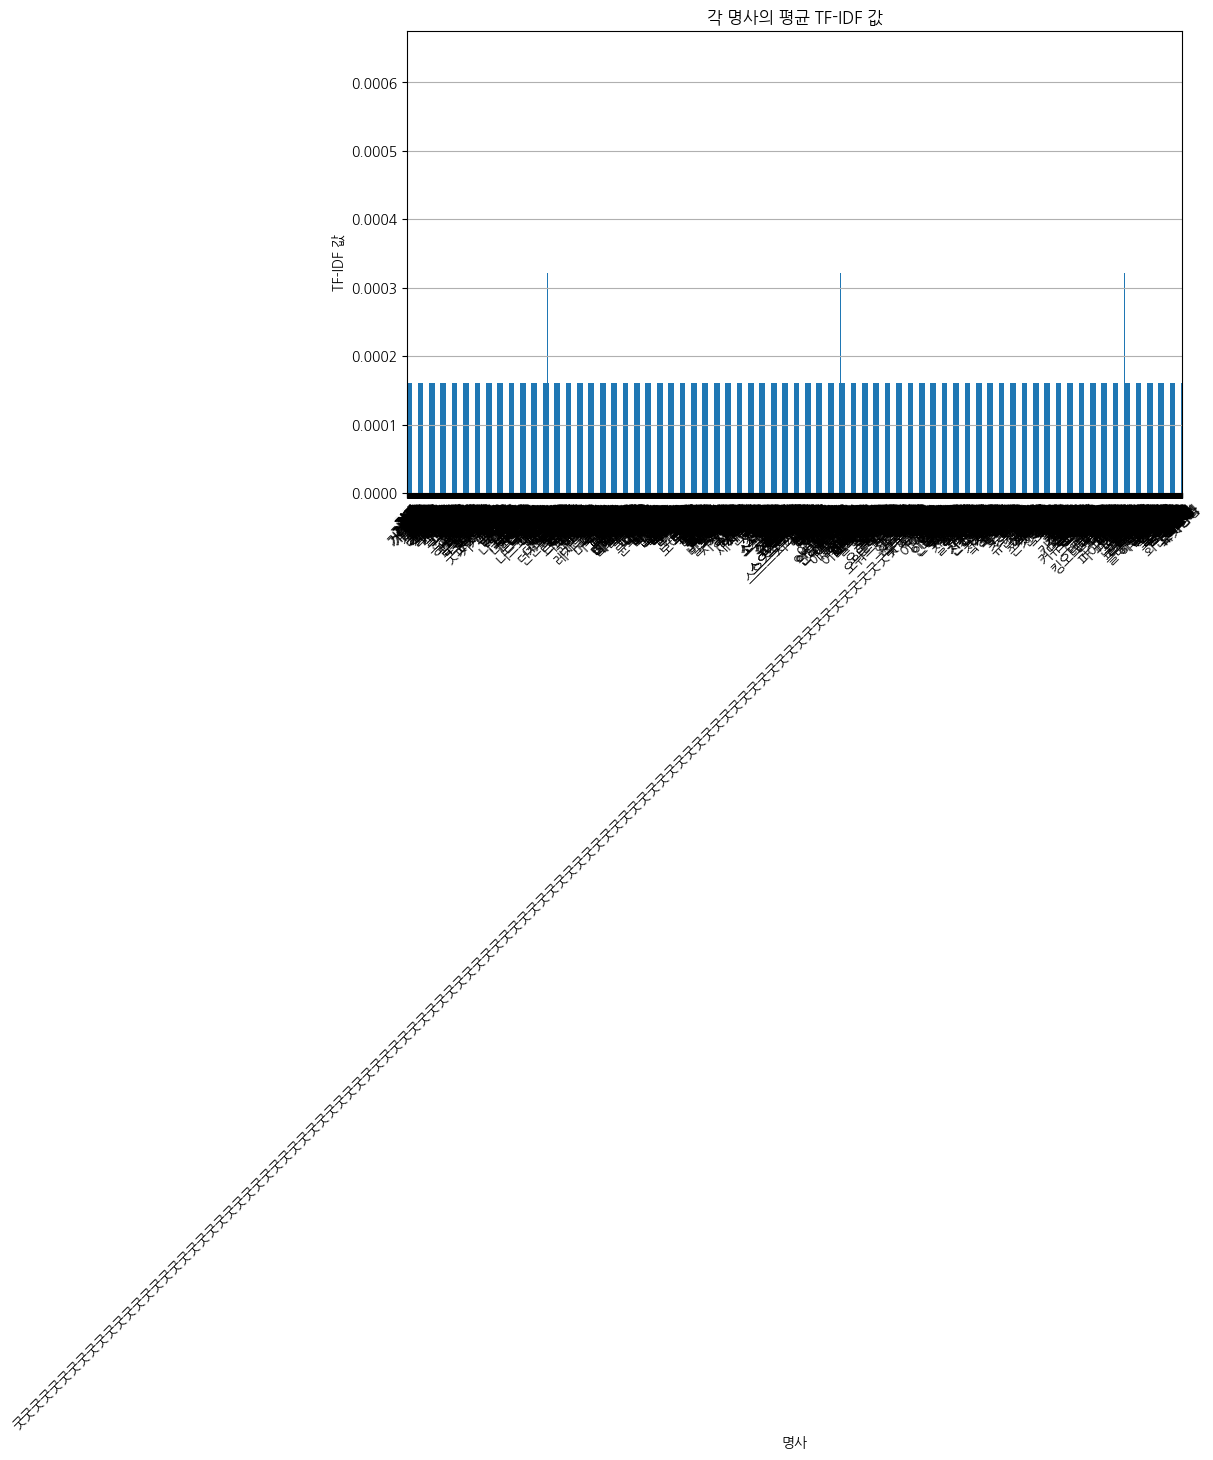

In [101]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# TF-IDF 값들의 평균 계산
tfidf_mean = tfidf_df.mean()

# TF-IDF 값들을 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
tfidf_mean.plot(kind='bar')
plt.title('각 명사의 평균 TF-IDF 값')
plt.xlabel('명사')
plt.ylabel('TF-IDF 값')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 네트워크 군집분석

In [102]:
okt = Okt()

# 명사 추출 함수
def extract_nouns(text):
    return okt.nouns(text)

# 'review_list'가 '긍정'인 '댓글' 열에서 명사 추출하여 'nouns' 열에 적용
df_reviews.loc[df_reviews['감정'] == '긍정', 'nouns'] = df_reviews[df_reviews['감정'] == '긍정']['reviews'].apply(extract_nouns)

In [103]:
# 네트워크 그래프 생성 및 연결 중심성 계산 함수
def calculate_centrality(df):
    G = nx.Graph()

    for nouns in df['nouns'].dropna():  # 결측값이 있을 수 있으므로 dropna() 추가
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(list(centrality.items()), columns=['명사', '연결 중심성'])
    return centrality_df, G

# 연결 중심성 계산
centrality_df, G = calculate_centrality(df_reviews)

In [104]:
# 명사 빈도 데이터프레임 생성
nouns_df = pd.merge(centrality_df, noun_df_freq[['명사', '긍정_빈도']], on='명사', how='left')

# NaN 값을 제거합니다.
nouns_df = nouns_df.dropna(subset=['긍정_빈도'])
nouns_df.sort_values(by='긍정_빈도', ascending=False)

명사    연결 중심성   긍정_빈도
0     배송  0.365043  2197.0
62    가격  0.356410  1825.0
35    사용  0.357876  1486.0
153   제품  0.329044  1437.0
21    가성  0.249715  1234.0
...   ..       ...     ...
3378  마메  0.013194     0.0
2259  뽁뽁  0.001303     0.0
2626  음량  0.014335     0.0
567   단점  0.071021     0.0
882   보기  0.030624     0.0

[5201 rows x 3 columns]

In [105]:
# 네트워크 그래프 생성 함수
def create_network_graph(df):
    G = nx.Graph()

    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    return G

def visualize_network(G, title, font_family='NanumGothic', font_size=10):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_size=[G.degree(n) * 10 for n in G.nodes],
            node_color='skyblue', font_size=font_size, alpha=0.7)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    # 노드에 라벨 추가
    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family='NanumGothic', font_size=font_size)
    plt.title(title)
    plt.show()

In [108]:
# 긍정과 부정 리뷰 분리
positive_reviews = df_reviews[df_reviews['감정'] == '긍정']
negative_reviews = df_reviews[df_reviews['감정'] == '부정']

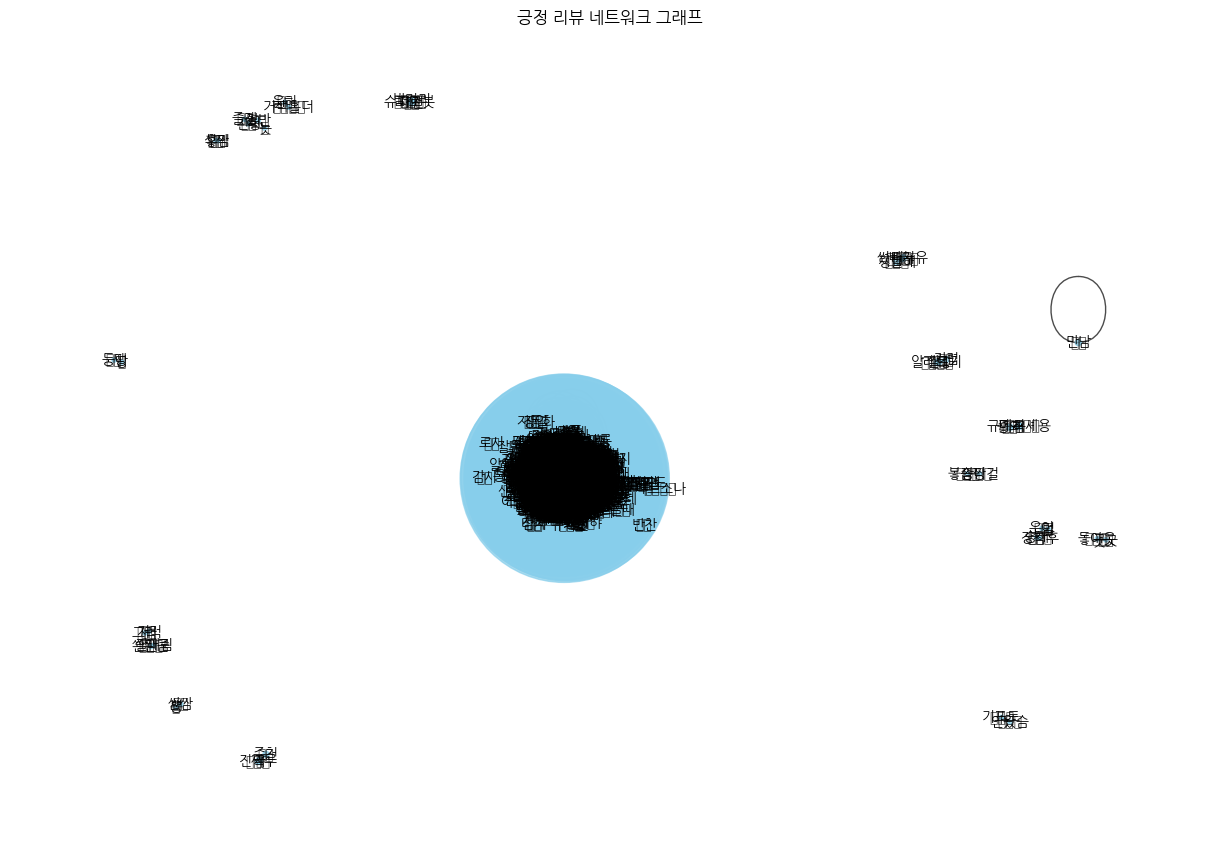

In [109]:
# 긍정 리뷰 네트워크 그래프 생성 및 시각화
positive_graph = create_network_graph(positive_reviews)
visualize_network(positive_graph, '긍정 리뷰 네트워크 그래프')

In [112]:
# 긍정 리뷰 텍스트 가져오기
positive_reviews_text = positive_reviews['reviews']

# CountVectorizer를 사용하여 키워드 빈도 분석
vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(positive_reviews_text.tolist())
words = vect.get_feature_names_out()
word_counts = bow_vect.toarray().sum(axis=0)

# 키워드와 빈도를 DataFrame으로 정리
word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=['Keyword', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# 상위 200개의 키워드만 추출
top_200_keywords = word_freq.head(200)
print(top_200_keywords)

    Keyword  Frequency
0        배송       2197
1        가격       1825
2        사용       1486
3        제품       1437
4        가성       1234
..      ...        ...
195      먼지         39
196      카드         39
197      질감         39
198      가능         39
199      바람         38

[200 rows x 2 columns]


In [113]:
# 상위 200개 키워드 표 생성
top_200_keywords['Rank'] = range(1, 201)
top_200_keywords = top_200_keywords[['Rank', 'Keyword', 'Frequency']]

print(top_200_keywords)

     Rank Keyword  Frequency
0       1      배송       2197
1       2      가격       1825
2       3      사용       1486
3       4      제품       1437
4       5      가성       1234
..    ...     ...        ...
195   196      먼지         39
196   197      카드         39
197   198      질감         39
198   199      가능         39
199   200      바람         38

[200 rows x 3 columns]


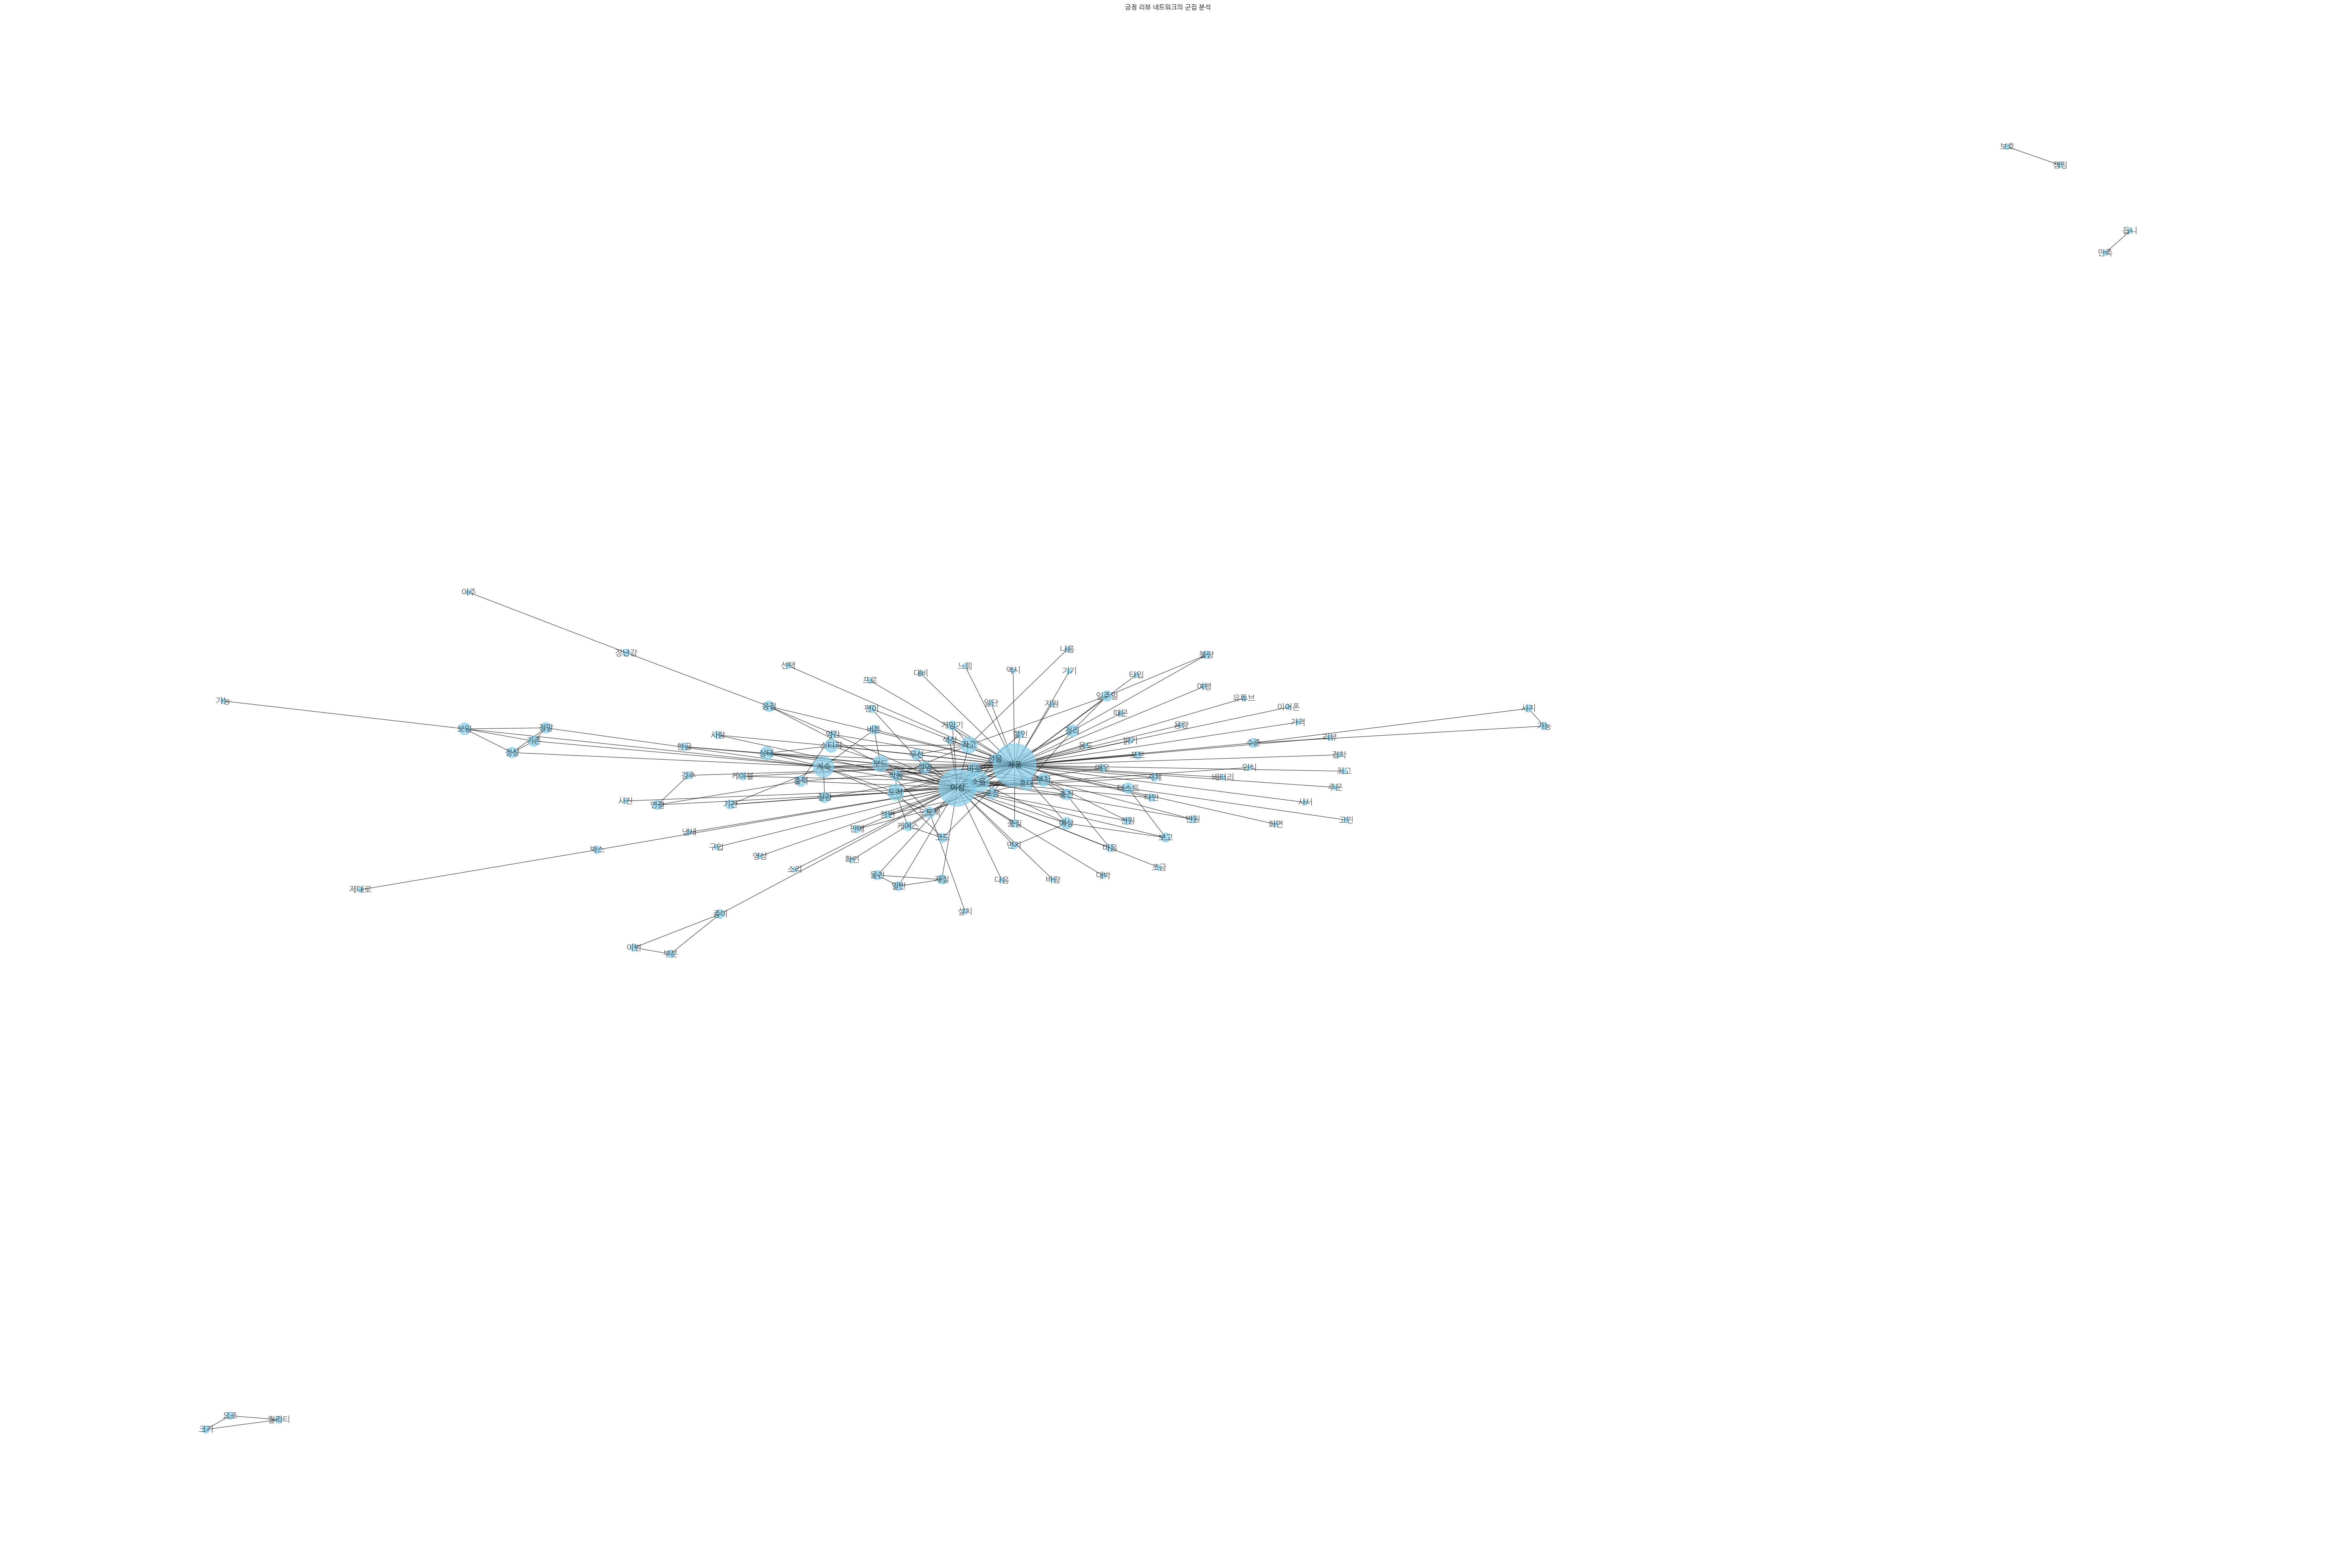

In [114]:
# 출현 빈도가 높은 200개의 핵심 키워드의 연결 및 연결 강도
top_keywords = top_200_keywords['Keyword'].tolist()

# 키워드 쌍 빈도 계산
bow_vect_top = vect.transform(positive_reviews_text.tolist())
co_occurrence = (bow_vect_top.T * bow_vect_top).toarray()
np.fill_diagonal(co_occurrence, 0)  # 자기 자신과의 연관성을 0으로 설정

# 그래프 생성
G = nx.Graph()

for i in range(len(top_keywords)):
    for j in range(i + 1, len(top_keywords)):
        if co_occurrence[i, j] > 0:
            G.add_edge(top_keywords[i], top_keywords[j], weight=co_occurrence[i, j])

# 그래프 시각화
plt.figure(figsize=(60, 40))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.degree(n) * 100 for n in G.nodes],
        node_color='skyblue', font_size=15, alpha=0.7, font_family='NanumGothic')

plt.title('긍정 리뷰 네트워크의 군집 분석')
plt.show()

In [115]:
okt = Okt()

# 명사 추출 함수
def extract_nouns(text):
    return okt.nouns(text)

# 'review_list'가 '부정'인 '댓글' 열에서 명사 추출하여 'nouns' 열에 적용
df_reviews.loc[df_reviews['감정'] == '부정', 'nouns'] = df_reviews[df_reviews['감정'] == '부정']['reviews'].apply(extract_nouns)


In [116]:
# 네트워크 그래프 생성 및 연결 중심성 계산
def calculate_centrality(df):
    G = nx.Graph()

    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(list(centrality.items()), columns=['명사', '연결 중심성'])
    return centrality_df, G

# 연결 중심성 계산
centrality_df, G = calculate_centrality(df_reviews)

In [117]:
# 명사 빈도 데이터프레임 생성
nouns_df = pd.merge(centrality_df, noun_df_freq[['명사', '부정_빈도']], on='명사', how='left')

# NaN 값을 제거합니다.
nouns_df = nouns_df.dropna(subset=['부정_빈도'])
nouns_df.sort_values(by='부정_빈도', ascending=False)

명사    연결 중심성  부정_빈도
62      가격  0.389969  351.0
35      사용  0.392505  327.0
157     제품  0.360101  287.0
0       배송  0.377994  254.0
3       생각  0.308960  197.0
...    ...       ...    ...
3882   측정값  0.002536    0.0
3883    직행  0.003522    0.0
3885    청음  0.001550    0.0
3886   유트브  0.002818    0.0
7190  꼽았는데  0.000986    0.0

[6037 rows x 3 columns]

In [118]:
# 네트워크 그래프 생성 함수
def create_network_graph(df):
    G = nx.Graph()

    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    return G

def visualize_network(G, title, font_family='NanumGothic', font_size=10):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_size=[G.degree(n) * 10 for n in G.nodes],
            node_color='skyblue', font_size=font_size, alpha=0.7)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    # 노드에 라벨 추가
    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family='NanumGothic', font_size=font_size)
    plt.title(title)
    plt.show()

In [119]:
# 긍정과 부정 리뷰 분리
positive_reviews = df_reviews[df_reviews['감정'] == '긍정']
negative_reviews = df_reviews[df_reviews['감정'] == '부정']

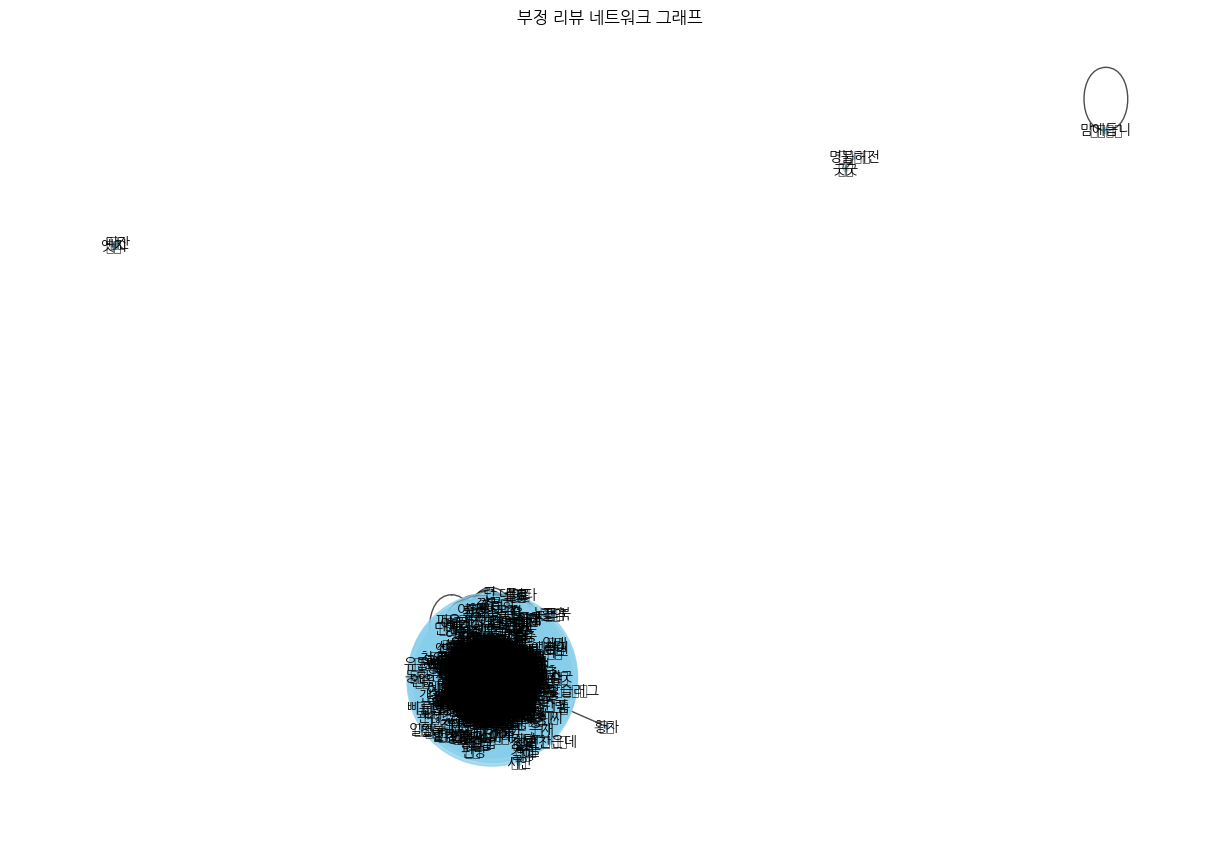

In [120]:
# 부정 리뷰 네트워크 그래프 생성 및 시각화
negative_graph = create_network_graph(negative_reviews)
visualize_network(negative_graph, '부정 리뷰 네트워크 그래프')

In [121]:
# 부정 리뷰 텍스트 가져오기
negative_reviews_text = negative_reviews['reviews']

# CountVectorizer를 사용하여 키워드 빈도 분석
vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(negative_reviews_text.tolist())
words = vect.get_feature_names_out()
word_counts = bow_vect.toarray().sum(axis=0)

# 키워드와 빈도를 DataFrame으로 정리
word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=['Keyword', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# 상위 200개의 키워드만 추출
top_200_keywords = word_freq.head(200)
top_200_keywords

Keyword  Frequency
0        가격        351
1        사용        327
2        제품        287
3        배송        254
4        생각        197
..      ...        ...
195      삼성         13
196      인치         13
197      천원         13
198      작고         13
199      사지         13

[200 rows x 2 columns]

In [122]:
# 상위 200개 키워드 표 생성
top_200_keywords['Rank'] = range(1, 201)
top_200_keywords = top_200_keywords[['Rank', 'Keyword', 'Frequency']]

top_200_keywords

Rank Keyword  Frequency
0       1      가격        351
1       2      사용        327
2       3      제품        287
3       4      배송        254
4       5      생각        197
..    ...     ...        ...
195   196      삼성         13
196   197      인치         13
197   198      천원         13
198   199      작고         13
199   200      사지         13

[200 rows x 3 columns]

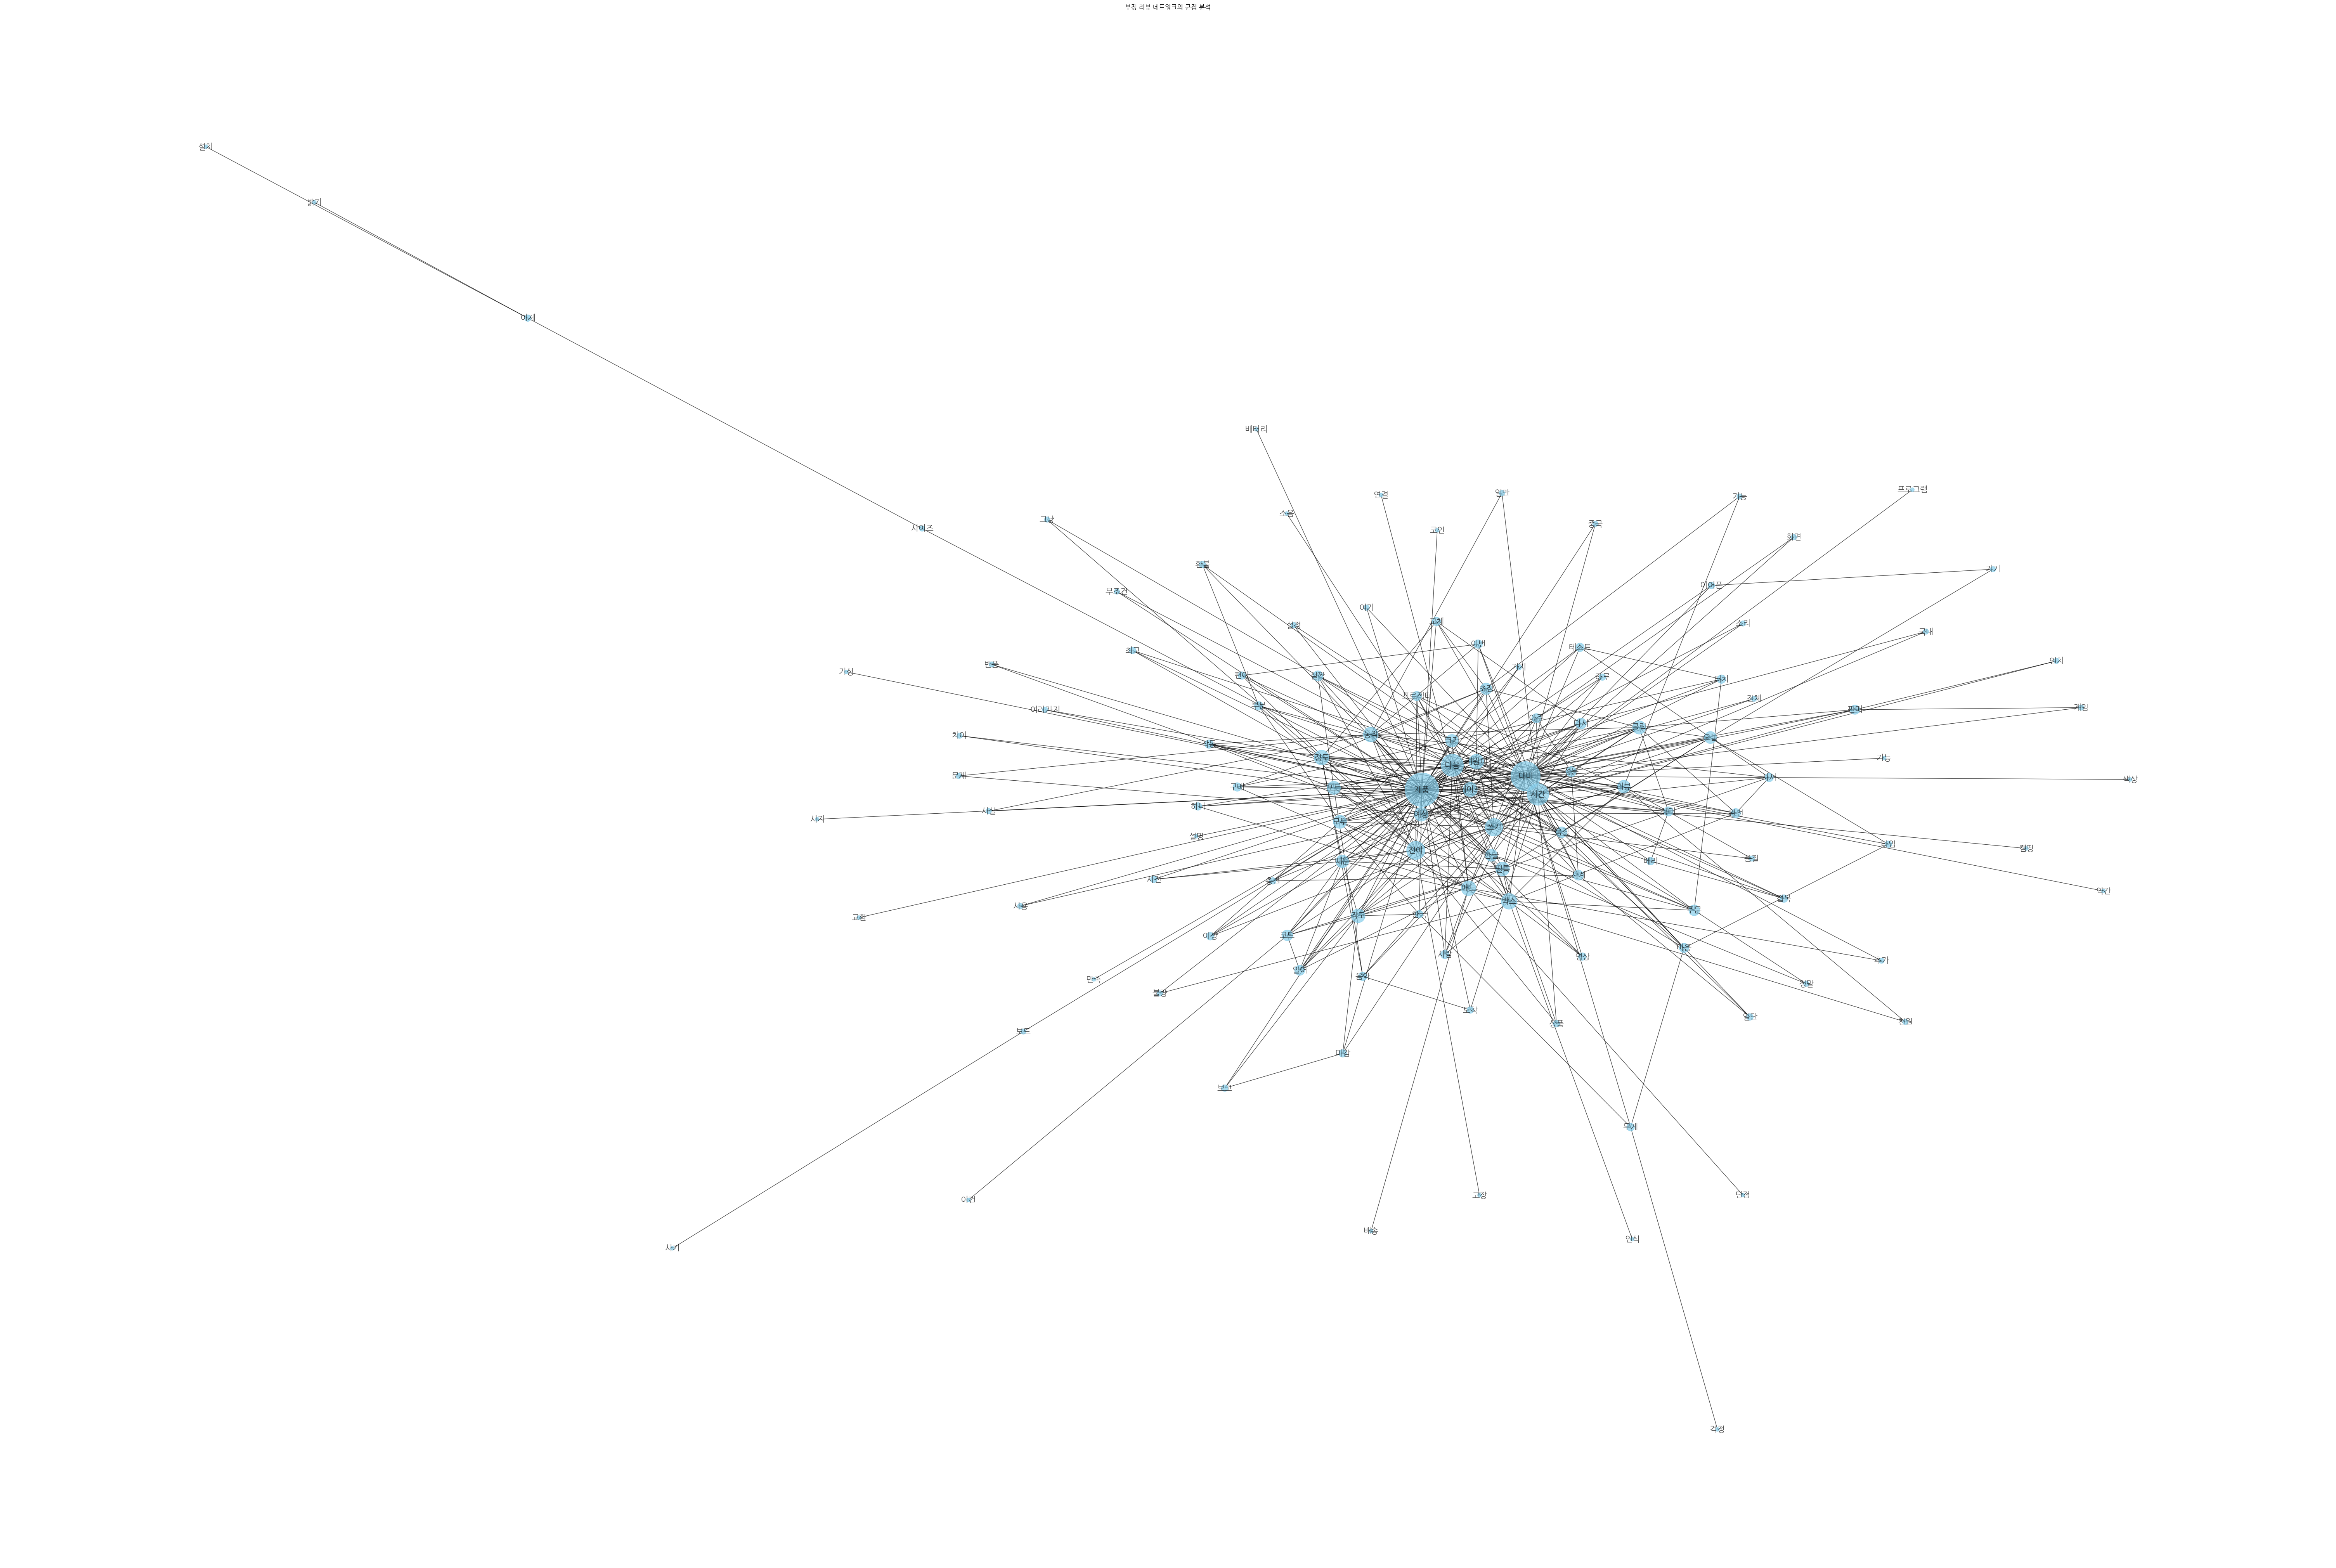

In [123]:
# 출현 빈도가 높은 200개의 핵심 키워드의 연결 및 연결 강도
top_keywords = top_200_keywords['Keyword'].tolist()

# 키워드 쌍 빈도 계산
bow_vect_top = vect.transform(positive_reviews_text.tolist())
co_occurrence = (bow_vect_top.T * bow_vect_top).toarray()
np.fill_diagonal(co_occurrence, 0)  # 자기 자신과의 연관성을 0으로 설정

# 그래프 생성
G = nx.Graph()

for i in range(len(top_keywords)):
    for j in range(i + 1, len(top_keywords)):
        if co_occurrence[i, j] > 0:
            G.add_edge(top_keywords[i], top_keywords[j], weight=co_occurrence[i, j])

# 그래프 시각화
plt.figure(figsize=(60, 40))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.degree(n) * 50 for n in G.nodes],
        node_color='skyblue', font_size=15, alpha=0.7, font_family='NanumGothic')

plt.title('부정 리뷰 네트워크의 군집 분석')
plt.show()

In [124]:
!pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
    --------------------------------------- 0.4/24.0 MB 12.2 MB/s eta 0:00:02
   - -------------------------------------- 0.9/24.0 MB 11.8 MB/s eta 0:00:02
   -- ------------------------------------- 1.5/24.0 MB 11.6 MB/s eta 0:00:02
   --- ------------------------------------ 2.0/24.0 MB 11.6 MB/s eta 0:00:02
   ---- ----------------------------------- 2.5/24.0 MB 11.5 MB/s eta 0:00:02
   ----- ---------------------------------- 3.1/24.0 MB 11.5 MB/s eta 0:00:02
   ----- ---------------------------------- 3.6/24.0 MB 11.5 MB/s eta 0:00:02
   ------ --------------------------------- 4.1/24.0 MB 11.5 MB/s eta 0:00:02
   ------- -------------------------------- 4.6/24.0 MB 11.4 MB/s eta 0:00:02
   -------- ------------------------------- 5.2/24.0 MB 11.9 MB/s eta 0:00:02
   --------- ------------------------------ 5.7/24.0 MB 11.8 MB/s eta 0:00:02
   ---------- ----------------------------- 6.3/24.0 MB 11.8 MB/s eta 0:

In [125]:
df_reviews.head()

Unnamed: 0                                            reviews  감정분석결과  감정  \
0           0   배송은 생각보다 빨리도착했네요 손목 스트랩 쌍 레드 디자인 이쁘고 마감처리 깔끔하...       1  긍정   
1           1     배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천 ㅋ        1  긍정   
2           2   정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전...       1  긍정   
3           3   개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼...       1  긍정   
4           4                  아 배송은 일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다        1  긍정   

                                               nouns  
0  [배송, 생각, 도착, 손목, 스트랩, 쌍, 레드, 디자인, 마감, 처리, 스트랩,...  
1               [배송, 색상, 디자인, 마감, 처리, 가성, 비, 강력, 추천]  
2  [정말, 이상인, 듯, 만원, 나, 의, 리프, 팅, 스트랩, 비교, 기능, 전혀,...  
3    [개중, 개, 포장, 상태, 상품, 아무, 문제, 미끄럼, 방지, 처리, 가성, 비]  
4                        [배송, 일, 배송, 지연, 배송, 무료, 쿠폰]

In [135]:
df_reviews.to_csv('bert모델긍정부정.csv',encoding='utf-8-sig')

In [127]:
pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [131]:
!pip uninstall scipy

^C


In [132]:
!pip install scipy

In [133]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim import corpora

# 토큰 리스트 생성
tokenized_reviews = df_reviews['nouns'].tolist()

# 사전 및 코퍼스 생성
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]

# 토픽 분석 위한 LDA 모델 구축
k = 4 # 토픽 개수 설정
lda_model = LdaMulticore(corpus=corpus, num_topics=k, id2word=dictionary,
                         iterations=100, passes=10, workers=10)

# 토픽 출력
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

ImportError: cannot import name 'triu' from 'scipy.linalg' (c:\Users\user\.conda\envs\malcam\lib\site-packages\scipy\linalg\__init__.py)